# GRU
### Команда:
* [Ирина Цехановаич](https://www.instagram.com/ms_cehanovich/)
* [Никита Антонов](https://www.instagram.com/nickantonovv/)
* [Алексей Полоз](https://www.instagram.com/mr.poloz/)

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

import pandas as pd

## Импортируем данные

In [10]:
df1 = pd.read_csv('2014/1-Jan14.csv', parse_dates=['Date'], usecols=[0, 2, 8])
df2 = pd.read_csv('2014/2-Feb14.csv', parse_dates=['Date'], usecols=[0, 2, 8])
df = pd.concat([df1, df2])

## Общий вид данных

In [11]:
df.head()

,LinkRef,Date,Flow
0,AL1470,2014-01-18,59.25
1,AL1470,2014-01-18,37.50
2,AL1470,2014-01-18,37.50
3,AL1470,2014-01-18,37.50
4,AL1470,2014-01-18,37.50


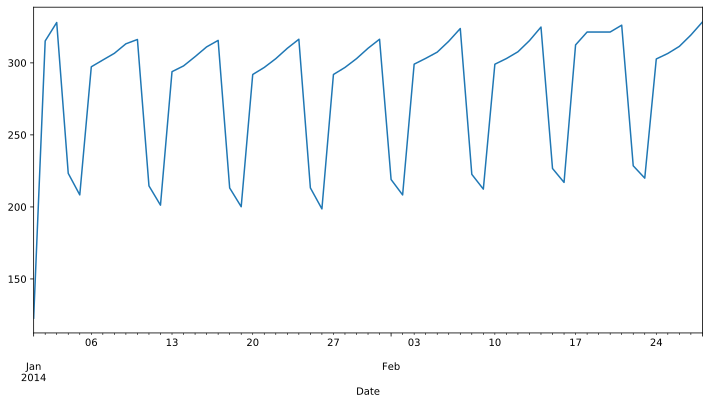

In [12]:
flow = df.groupby('Date').Flow.mean()
flow.plot()

## Строим Keras модель

In [13]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Using TensorFlow backend.


In [14]:
numpy.random.seed(1)

## Подготавливаем dataset

In [15]:
# df = df[df.Date == '2014-01-18 00:00:00']
df = df[df.LinkRef == 'AL1470']
df = df[["Flow"]]
dataset = df.values
dataset = df.astype('float32')

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Разбиваем на обучающую и тестовую выборки

In [17]:
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2832 2832


In [18]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [20]:
print(trainX, trainY)

[[0.1363201 ]
 [0.08289735]
 [0.08289735]
 ...
 [0.7301107 ]
 [0.7301107 ]
 [0.7749367 ]] [0.08289735 0.08289735 0.08289735 ... 0.7301107  0.7749367  0.7749367 ]


## Обучение

In [21]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
model = Sequential()
model.add(GRU(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.0240
Epoch 2/100
 - 3s - loss: 0.0037
Epoch 3/100
 - 3s - loss: 0.0037
Epoch 4/100
 - 3s - loss: 0.0037
Epoch 5/100
 - 3s - loss: 0.0037
Epoch 6/100
 - 3s - loss: 0.0037
Epoch 7/100
 - 3s - loss: 0.0037
Epoch 8/100
 - 3s - loss: 0.0037
Epoch 9/100
 - 3s - loss: 0.0037
Epoch 10/100
 - 3s - loss: 0.0037
Epoch 11/100
 - 3s - loss: 0.0037
Epoch 12/100
 - 3s - loss: 0.0037
Epoch 13/100
 - 3s - loss: 0.0037
Epoch 14/100
 - 3s - loss: 0.0037
Epoch 15/100
 - 3s - loss: 0.0037
Epoch 16/100
 - 3s - loss: 0.0037
Epoch 17/100
 - 3s - loss: 0.0037
Epoch 18/100
 - 3s - loss: 0.0037
Epoch 19/100
 - 3s - loss: 0.0037
Epoch 20/100
 - 3s - loss: 0.0037
Epoch 21/100
 - 3s - loss: 0.0037
Epoch 22/100
 - 3s - loss: 0.0037
Epoch 23/100
 - 3s - loss: 0.0037
Epoch 24/100
 - 3s - loss: 0.0037
Epoch 25/100
 - 3s - loss: 0.0037
Epoch 26/100
 - 3s - loss: 0.0037
Epoch 27/100
 - 3s - loss: 0.0037
Epoch 28/100
 - 3s - loss: 0.0037
Epoch 29/100
 - 3s - loss: 0.0037
Epoch 30/100
 - 3s - lo

## Прогнозируем

In [23]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(trainPredict, testPredict)

[[0.13584927]
 [0.08324762]
 [0.08324762]
 ...
 [0.7211101 ]
 [0.7211101 ]
 [0.7611944 ]] [[0.7611944 ]
 [0.62628365]
 [0.62628365]
 ...
 [0.08655876]
 [0.05521756]
 [0.05521756]]


In [24]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

## Метрики
### RMSE (Среднеквадратичное отклонение)

In [25]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.45 RMSE
Test Score: 23.49 RMSE


### MSA (Среднее абсолютное отклонение)

In [26]:
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSA' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSA' % (testScore))

Train Score: 9.58 MSA
Test Score: 9.45 MSA


### R<sup>2</sup>

In [27]:
trainScore = r2_score(trainY[0], trainPredict[:,0])
print('Train Score: %.2f R2' % (trainScore))
testScore = r2_score(testY[0], testPredict[:,0])
print('Test Score: %.2f R2' % (testScore))

Train Score: 0.96 R2
Test Score: 0.96 R2


## Строим график

In [28]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [29]:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
# print(len(trainPredict), (look_back*2), len(dataset))
# testPredictPlot[len(trainPredict)+(look_back*2)+1:(len(dataset)//1000+2)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

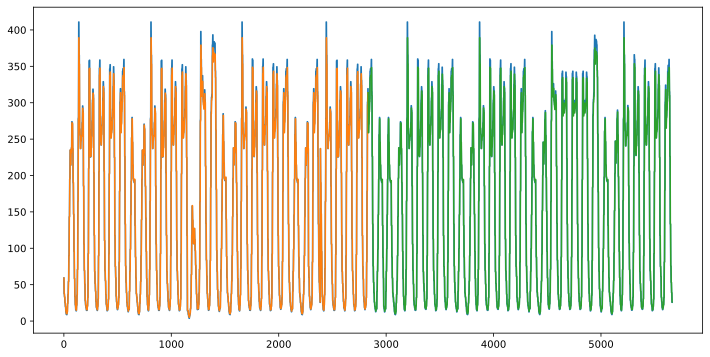

In [30]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()